In [ ]:
from pydantic import BaseModel
import pandas as pd 
import os
from dotenv import load_dotenv
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
load_dotenv()
import os 
from langchain_core.messages import HumanMessage, SystemMessage
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
from typing import Annotated, Literal, TypedDict

import bs4

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.utilities import GoogleSerperAPIWrapper
from langchain.load import dumps, loads
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# llm = ChatGoogleGenerativeAI(
#     model="gemini-1.5-pro",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     # other params...
# )
llm = ChatGroq(temperature=0, model_name="Gemma2-9b-It")
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from langchain_core.tools import tool
from langgraph.graph import StateGraph,MessagesState,END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import START,END


USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/puzan/anaconda3/envs/study/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [3]:
def multiply(a,b):
    """multi"""
    return a * b

In [4]:
llm_with_tools=llm.bind_tools([multiply])

In [5]:
llm_with_tools.invoke("what is the use of hari")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m3hz', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 938, 'total_tokens': 1026, 'completion_time': 0.16, 'prompt_time': 0.029732724, 'queue_time': 0.022445032, 'total_time': 0.189732724}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3917fd24-bef7-48bb-a0fd-ec5bbb6d42d0-0', tool_calls=[{'name': 'multiply', 'args': {'a': 10, 'b': 2}, 'id': 'call_m3hz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 938, 'output_tokens': 88, 'total_tokens': 1026})

In [6]:
from langgraph.graph import START,END


In [7]:
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [8]:
builder=StateGraph(MessagesState)
builder.add_node("tool_llm",tool_calling_llm)
builder.add_node("tools",ToolNode([multiply]))
builder.add_edge(START,"tool_llm")
builder.add_conditional_edges(
    "tool_llm",
    tools_condition
)
builder.add_edge("tools",END)

graph=builder.compile()


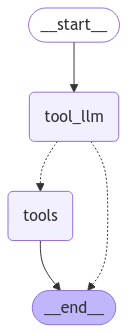

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
messages=HumanMessage(content="hi what is machine learning")

In [11]:
messages=graph.invoke({"messages":messages})

In [12]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hi what is machine learning
================================== Ai Message ==================================
Tool Calls:
  multiply (call_w5ky)
 Call ID: call_w5ky
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: multiply

200


In [13]:
messages

{'messages': [HumanMessage(content='hi what is machine learning', additional_kwargs={}, response_metadata={}, id='842e7d6e-e755-4d2f-b2e9-d0a0972aeceb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w5ky', 'function': {'arguments': '{"a":10,"b":20}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 937, 'total_tokens': 1026, 'completion_time': 0.161818182, 'prompt_time': 0.044229828, 'queue_time': 0.020038381000000008, 'total_time': 0.20604801}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7ee08069-ec6c-4a9e-8dba-c8cf73fc585a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 10, 'b': 20}, 'id': 'call_w5ky', 'type': 'tool_call'}], usage_metadata={'input_tokens': 937, 'output_tokens': 89, 'total_tokens': 1026}),
  ToolMessage(content='200', name='multiply', id='d207c4a8-e104-434f-8eac-09d8681b156b', tool_call_